In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sklearn.model_selection as model_selection
import sklearn.preprocessing as preprocessing
import seaborn as sns
import sklearn.linear_model as linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
ad_clicks_csv = pd.read_csv('../Resources/network_ad_demographics.csv')
ad_clicks = ad_clicks_csv.drop('User ID', 1)
ad_clicks

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0
...,...,...,...,...
395,Female,46,41000,1
396,Male,51,23000,1
397,Female,50,20000,1
398,Male,36,33000,0


In [3]:
def data_summary(df):
    for column in df.columns:
        print (column)
        if df.dtypes[column] == np.object: # Categorical data
            print (df[column].value_counts())
        else:
            print (df[column].describe())
            
        print ('\n')
    
data_summary(ad_clicks)

Gender
Female    204
Male      196
Name: Gender, dtype: int64


Age
count    400.000000
mean      37.655000
std       10.482877
min       18.000000
25%       29.750000
50%       37.000000
75%       46.000000
max       60.000000
Name: Age, dtype: float64


EstimatedSalary
count       400.000000
mean      69742.500000
std       34096.960282
min       15000.000000
25%       43000.000000
50%       70000.000000
75%       88000.000000
max      150000.000000
Name: EstimatedSalary, dtype: float64


Purchased
count    400.000000
mean       0.357500
std        0.479864
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Purchased, dtype: float64




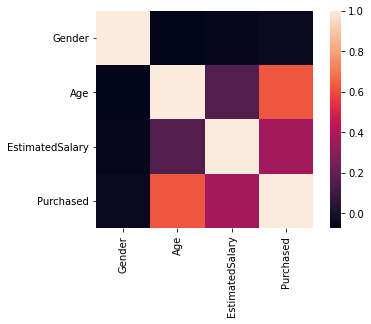

,Gender,Age,EstimatedSalary,Purchased
395,0,46,41000,1
396,1,51,23000,1
397,0,50,20000,1
398,1,36,33000,0
399,0,49,36000,1


In [4]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders


# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(ad_clicks)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

encoded_data.tail(5)

In [16]:
encoded_data, encoders = number_encode_features(ad_clicks)
new_series = encoded_data["Purchased"]
new_series #y-values 

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Purchased, Length: 400, dtype: int64

LogReg (non-binary independents)

In [17]:
# Split and scale the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(encoded_data[encoded_data.columns.drop("Purchased")], new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

In [21]:
# logistic regression
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [19]:
print(accuracy_score(y_test, y_pred))

0.8333333333333334


Variable Coefficients

Index(['Gender', 'Age', 'EstimatedSalary'], dtype='object')


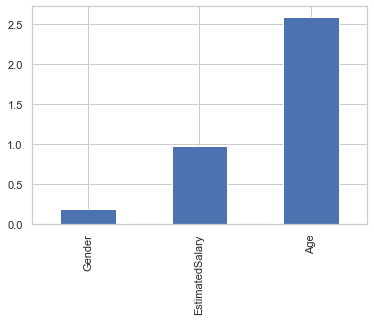

Age                2.594517
EstimatedSalary    0.971577
Gender             0.190378
dtype: float64


In [9]:
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
print (X_train.columns)
coefs = coefs.sort_values()
sns.set(style='whitegrid')
plt.subplot(1,1,1)
coefs.plot(kind="bar")
plt.show()
print (coefs.sort_values(ascending = False))

Creating Age Groups

In [11]:
age_conditions = [
(ad_clicks.Age <= 25) & (ad_clicks.Age >= 18),
(ad_clicks.Age <= 35) & (ad_clicks.Age >= 26),
(ad_clicks.Age <= 45) & (ad_clicks.Age >= 36),
(ad_clicks.Age <= 55) & (ad_clicks.Age >= 46),
(ad_clicks.Age >= 56),
]
age_values = ["18-25","26-35","36-45","46-55","55+"]
ad_clicks['Age Group'] = np.select(age_conditions, age_values)

Creating Salary Groups

In [12]:
salary_conditions = [
(ad_clicks.EstimatedSalary <= 55000) & (ad_clicks.EstimatedSalary >= 15000),
(ad_clicks.EstimatedSalary <= 100000) & (ad_clicks.EstimatedSalary > 55000),
(ad_clicks.EstimatedSalary <= 150000) & (ad_clicks.EstimatedSalary > 100000),
]
salary_values = ["15k-55k","55k-100k","100k-150k"]
ad_clicks['Salary Group'] = np.select(salary_conditions, salary_values)
del ad_clicks['Age']
del ad_clicks['EstimatedSalary']
ad_clicks

,Gender,Purchased,Age Group,Salary Group
0,Male,0,18-25,15k-55k
1,Male,0,26-35,15k-55k
2,Female,0,26-35,15k-55k
3,Female,0,26-35,55k-100k
4,Male,0,18-25,55k-100k
...,...,...,...,...
395,Female,1,46-55,15k-55k
396,Male,1,46-55,15k-55k
397,Female,1,46-55,15k-55k
398,Male,0,36-45,15k-55k


One-hot Encoding Categorical Groupings

In [13]:
# Select the numeric columns
numeric_subset = ad_clicks.select_dtypes('number')
categorical_subset = ad_clicks.select_dtypes('object')

# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset[categorical_subset.columns])
#drop Purchased column
numeric_subset = numeric_subset.drop("Purchased", axis=1)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
print (features.head())

   Gender_Female  Gender_Male  Age Group_18-25  Age Group_26-35  \
0              0            1                1                0   
1              0            1                0                1   
2              1            0                0                1   
3              1            0                0                1   
4              0            1                1                0   

   Age Group_36-45  Age Group_46-55  Age Group_55+  Salary Group_100k-150k  \
0                0                0              0                       0   
1                0                0              0                       0   
2                0                0              0                       0   
3                0                0              0                       0   
4                0                0              0                       0   

   Salary Group_15k-55k  Salary Group_55k-100k  
0                     1                      0  
1                     1       

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, new_series, train_size=0.70)
scaler = preprocessing.StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
cls.fit(X_train, y_train)
coefs2 = pd.Series(cls.coef_[0], index=X_train.columns)
print (coefs2.sort_values(ascending = False))


Age Group_46-55           1.017583
Age Group_55+             0.944927
Salary Group_100k-150k    0.922855
Gender_Male               0.165492
Age Group_36-45          -0.054622
Gender_Female            -0.165492
Salary Group_15k-55k     -0.277735
Salary Group_55k-100k    -0.446256
Age Group_26-35          -0.573744
Age Group_18-25          -1.032060
dtype: float64


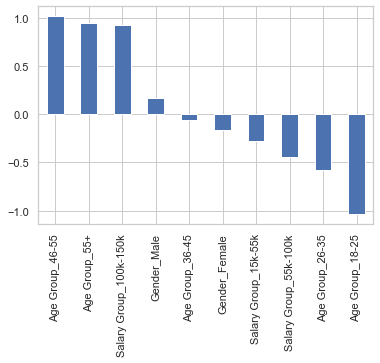

In [15]:
plt.subplot(1,1,1)
(coefs2.sort_values(ascending = False)).plot(kind="bar")
plt.show()
sns.set(style='whitegrid')